In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.linear as frl
%matplotlib inline

### Generate Data

In [2]:
st = np.random.RandomState(89320432)
N, K1, K2 = 1_000_000, 10, 100

In [3]:
df = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df['y'] = 3*df['x1'] + 2*df['x2'] + 0.1*df['id1'] + 0.01*df['id2'] + st.randn(N)
df['lEp'] = 0.6*df['x1'] + 0.2*df['x2'] + 0.2*df['id1']/100 + 0.5*df['id2']/100
df['Ep'] = np.exp(df['lEp'])
df['p'] = np.random.poisson(df['Ep'])
df.head()

,id1,id2,x1,x2,y,lEp,Ep,p
0,4,99,-0.232286,-1.106499,1.111238,0.142329,1.152956,1
1,8,98,0.457063,0.585081,5.948498,0.897254,2.452858,2
2,8,73,0.761536,-0.705039,3.017252,0.696914,2.007547,5
3,8,40,-0.251006,-0.884939,-2.216396,-0.111591,0.894410,1
4,6,90,-1.211539,1.763510,2.938151,0.087778,1.091746,0


### Normal OLS

In [4]:
%time smf.ols('y ~ x1 + x2', data=df).fit().params

/home/doug/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


CPU times: user 852 ms, sys: 674 ms, total: 1.53 s
Wall time: 375 ms


Intercept    0.944116
x1           2.999261
x2           2.000620
dtype: float64

In [5]:
%time frl.ols(y='y', x=['x1', 'x2'], data=df)

CPU times: user 141 ms, sys: 142 ms, total: 282 ms
Wall time: 50.7 ms


,coeff,stderr,low95,high95,pvalue
intercept,0.944116,0.001081,0.941998,0.946234,0.0
x1,2.999261,0.001080,2.997144,3.001378,0.0
x2,2.000620,0.001079,1.998505,2.002735,0.0


### Sparse OLS

In [6]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

CPU times: user 1.16 s, sys: 143 ms, total: 1.31 s
Wall time: 1.2 s


,coeff,stderr,low95,high95,pvalue
intercept,-0.009189,0.010404,-0.029580,0.011202,0.188546
x1,2.999921,0.000999,2.997962,3.001879,0.000000
x2,2.000417,0.000998,1.998461,2.002374,0.000000
id1=1,0.105988,0.004473,0.097222,0.114754,0.000000
id1=2,0.205539,0.004467,0.196783,0.214295,0.000000
...,...,...,...,...,...
id2=95,0.941612,0.014122,0.913934,0.969290,0.000000
id2=96,0.963148,0.014151,0.935412,0.990885,0.000000
id2=97,0.980529,0.014158,0.952781,1.008278,0.000000
id2=98,1.015244,0.014146,0.987518,1.042970,0.000000


In [7]:
%time _ = frl.ols(y='y', x=['x1', 'x2'], fe=[('id1', 'id2')], data=df)

CPU times: user 1.24 s, sys: 78.9 ms, total: 1.32 s
Wall time: 1.32 s


In [8]:
%time _ = frl.ols(y='y', x=['x1', 'x2'], fe=[('id1', 'id2')], data=df, drop=None, intercept=False)

CPU times: user 1.15 s, sys: 50.8 ms, total: 1.2 s
Wall time: 1.2 s


### Poisson

In [9]:
import tensorflow as tf
import fastreg.general as frg

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [25]:
%time table = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, epochs=3)

Train on 1000000 samples
Epoch 1/3
4890119/1000000 [==================================================================================================================================================] - 7s 1us/sample - loss: 0.5354 - accuracy: 0.3212
Epoch 2/3
4890119/1000000 [==================================================================================================================================================] - 6s 1us/sample - loss: 0.5208 - accuracy: 0.3218
Epoch 3/3
4890119/1000000 [==================================================================================================================================================] - 6s 1us/sample - loss: 0.5104 - accuracy: 0.3218
CPU times: user 33.6 s, sys: 1.93 s, total: 35.6 s
Wall time: 32.8 s


In [26]:
table

,coeff,stderr,low95,high95,pvalue
intercept,0.194470,0.008939,0.176950,0.211989,0.000000e+00
x1,0.611422,0.000790,0.609874,0.612970,0.000000e+00
x2,0.203949,0.000791,0.202399,0.205500,0.000000e+00
id1=1,0.019893,0.003546,0.012943,0.026844,1.013550e-08
id1=2,-0.035029,0.003554,-0.041994,-0.028063,0.000000e+00
...,...,...,...,...,...
id2=95,0.257444,0.011123,0.235644,0.279244,0.000000e+00
id2=96,0.304204,0.011147,0.282357,0.326051,0.000000e+00
id2=97,0.291566,0.011086,0.269837,0.313295,0.000000e+00
id2=98,0.292293,0.011139,0.270461,0.314125,0.000000e+00


In [27]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

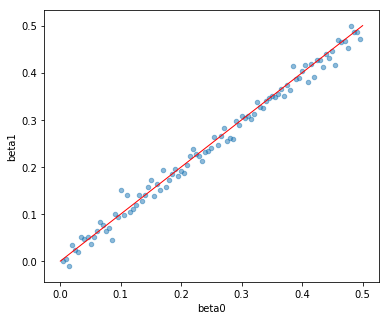

In [28]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);